In [ ]:
# importing required libraries
import numpy as np
import pandas as pd
from matplotlib import dates
import warnings
from sklearn.model_selection import TimeSeriesSplit
import datetime as dt
import pandas_profiling
# visualisations
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error,mean_squared_error
from xgboost import XGBRegressor
from xgboost import plot_importance
warnings.filterwarnings(action='ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Problem Statement
https://datahack.analyticsvidhya.com/contest/job-a-thon-november-2022/#ProblemStatement

`Objective`:

Your task at hand is to build a machine learning/deep learning approach to forecast the total energy demand on an hourly basis for the next 3 years based on past trends.



## 1.Reading in input data

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/AV_NOV_2022/data/test_WudNWDM.csv', index_col='datetime', parse_dates=True)
train_df = pd.read_csv('/content/drive/MyDrive/AV_NOV_2022/data/train_IxoE5JN.csv', index_col='datetime', parse_dates=True)
sub_df = pd.read_csv('/content/drive/MyDrive/AV_NOV_2022/data/sample_submission_jn0a7vR.csv')

## 2.EDA

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 94992 entries, 2008-03-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   row_id  94992 non-null  int64  
 1   energy  93092 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 2.2 MB


In [ ]:
train_df.dropna().info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93092 entries, 2008-03-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   row_id  93092 non-null  int64  
 1   energy  93092 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 2.1 MB


In [ ]:
train_df.resample('M').apply(lambda df: df['energy'].isnull().sum())

datetime
2008-03-31    12
2008-04-30    12
2008-05-31    10
2008-06-30    19
2008-07-31    10
              ..
2018-08-31    15
2018-09-30    14
2018-10-31    18
2018-11-30     9
2018-12-31    15
Freq: M, Length: 130, dtype: int64

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26304 entries, 2019-01-01 00:00:00 to 2021-12-31 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   row_id  26304 non-null  int64
dtypes: int64(1)
memory usage: 411.0 KB


In [ ]:
print(sub_df.shape)
sub_df.head(2)

(26304, 2)


,row_id,energy
0,94993,1702.995014
1,94994,1702.995014


In [ ]:
train_df.shape, test_df.shape

((94992, 2), (26304, 1))

In [ ]:
display(train_df.head(2))
display(test_df.head(2) )
display(test_df.tail(2))

,row_id,energy
datetime,,
2008-03-01 00:00:00,1,1259.985563
2008-03-01 01:00:00,2,1095.541500


,row_id
datetime,
2019-01-01 00:00:00,94993
2019-01-01 01:00:00,94994


,row_id
datetime,
2021-12-31 22:00:00,121295
2021-12-31 23:00:00,121296


In [ ]:
train_df.dtypes,test_df.dtypes

(row_id      int64
 energy    float64
 dtype: object, row_id    int64
 dtype: object)

#### Energy consumption patterns

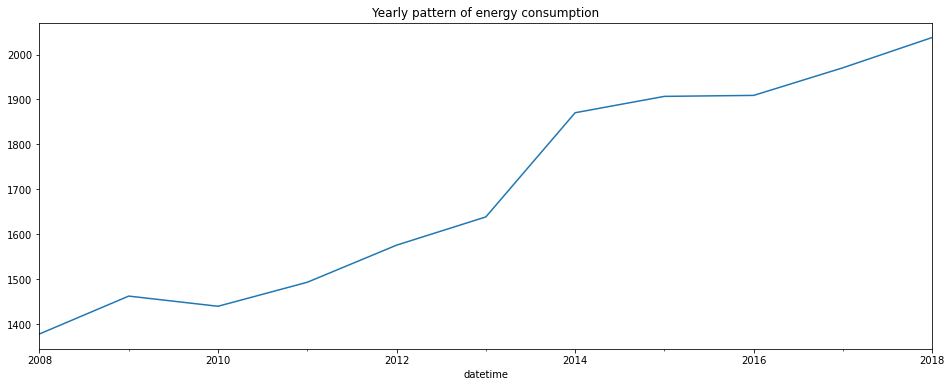

In [ ]:
title= 'Yearly pattern of energy consumption'
train_df['energy'].resample('Y').mean().plot(figsize=(16,6), title=title);

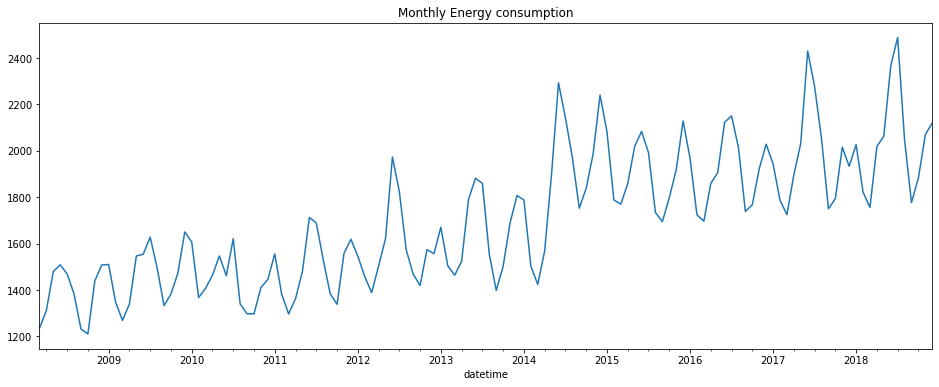

In [ ]:
title= 'Monthly Energy consumption'
train_df['energy'].resample('M').mean().plot(figsize=(16,6), title=title);

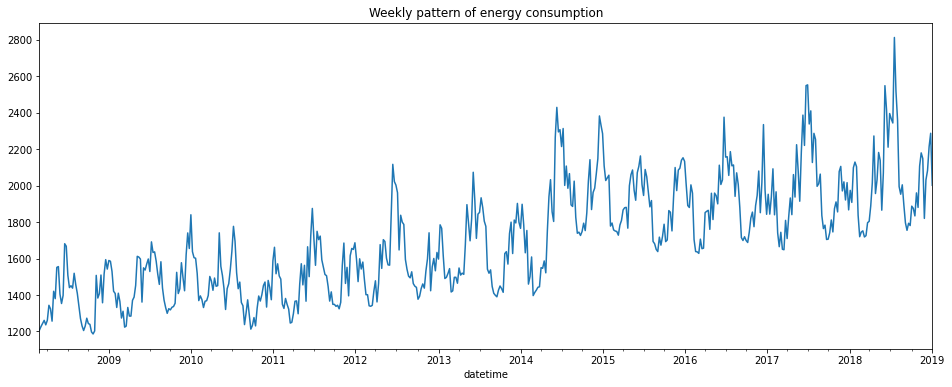

In [ ]:
title= 'Weekly pattern of energy consumption'
train_df['energy'].resample('W').mean().plot(figsize=(16,6), title=title);

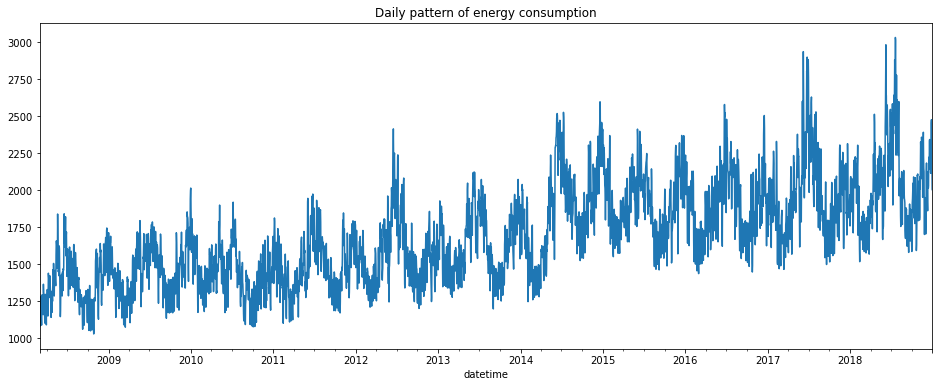

In [ ]:
title= 'Daily pattern of energy consumption'
train_df['energy'].resample('D').mean().plot(figsize=(16,6), title=title);

`Observation:`
#### Can observe clear seasonality in the energy consumption, it is more pronounced at monthly , weekly , daily levels

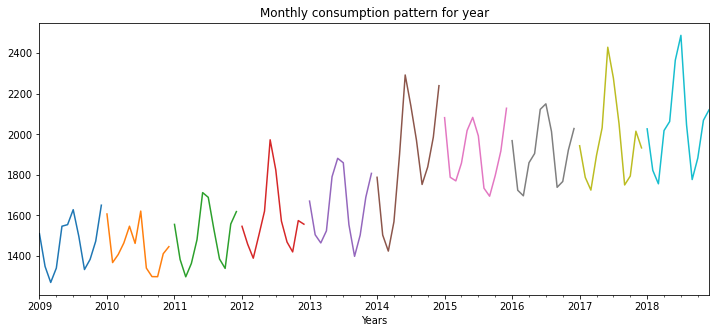

In [ ]:
for year in range(2009,2019,1):
    title= f'Monthly consumption pattern for year'
    train_df['energy'].loc[str(year)].resample('M').mean().plot(figsize=(12,5), title=title)
    plt.xlabel('Years')


In [ ]:
def consumption_patttern(df):
    years = [i for i in range(df.index.year.min(),df.index.year.max()+1,1)]
    # labels = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
    _, axes = plt.subplots(round(len(years)/3), 3, figsize=(20,20))
    print(axes.shape)
    for c,year in enumerate(years):
        i, j = divmod(c, 3)
        df1= df['energy'].loc[str(year)].resample('M').mean()
        labels =  df1.index.strftime('%B')
        sns.lineplot(x=df1.index, y= df1 , data= df1, ax=axes[i,j])
        axes[i,j].set_title(f'Energy consumption pattern for year {year}')
        axes[i,j].set_xlabel('Month')
        axes[i,j].set_xticklabels(labels=labels,rotation=30)
        # axes[i,j].xaxis.set_major_locator(dates.WeekdayLocator(byweekday=0))
        # axes[i,j].xaxis. .x_ticks(rotation=90)
        plt.tight_layout(pad=2.0)
        c+=1

In [ ]:
def month_from_index(df):
    df['month'] =  df.index.strftime('%B')
    return df

In [ ]:
(train_df
['2013']['energy']
.resample('M')
.mean()
.to_frame('energy')
.pipe(month_from_index)
# .boxplot(by='month',figsize=(12,5))
)
# plt.xticks(rotation=40);

,energy,month
datetime,,
2013-01-31,1670.484677,January
2013-02-28,1504.430678,February
2013-03-31,1464.075579,March
2013-04-30,1523.755591,April
2013-05-31,1790.807718,May
2013-06-30,1881.672419,June
2013-07-31,1859.608013,July
2013-08-31,1553.824592,August
2013-09-30,1397.959067,September


(4, 3)


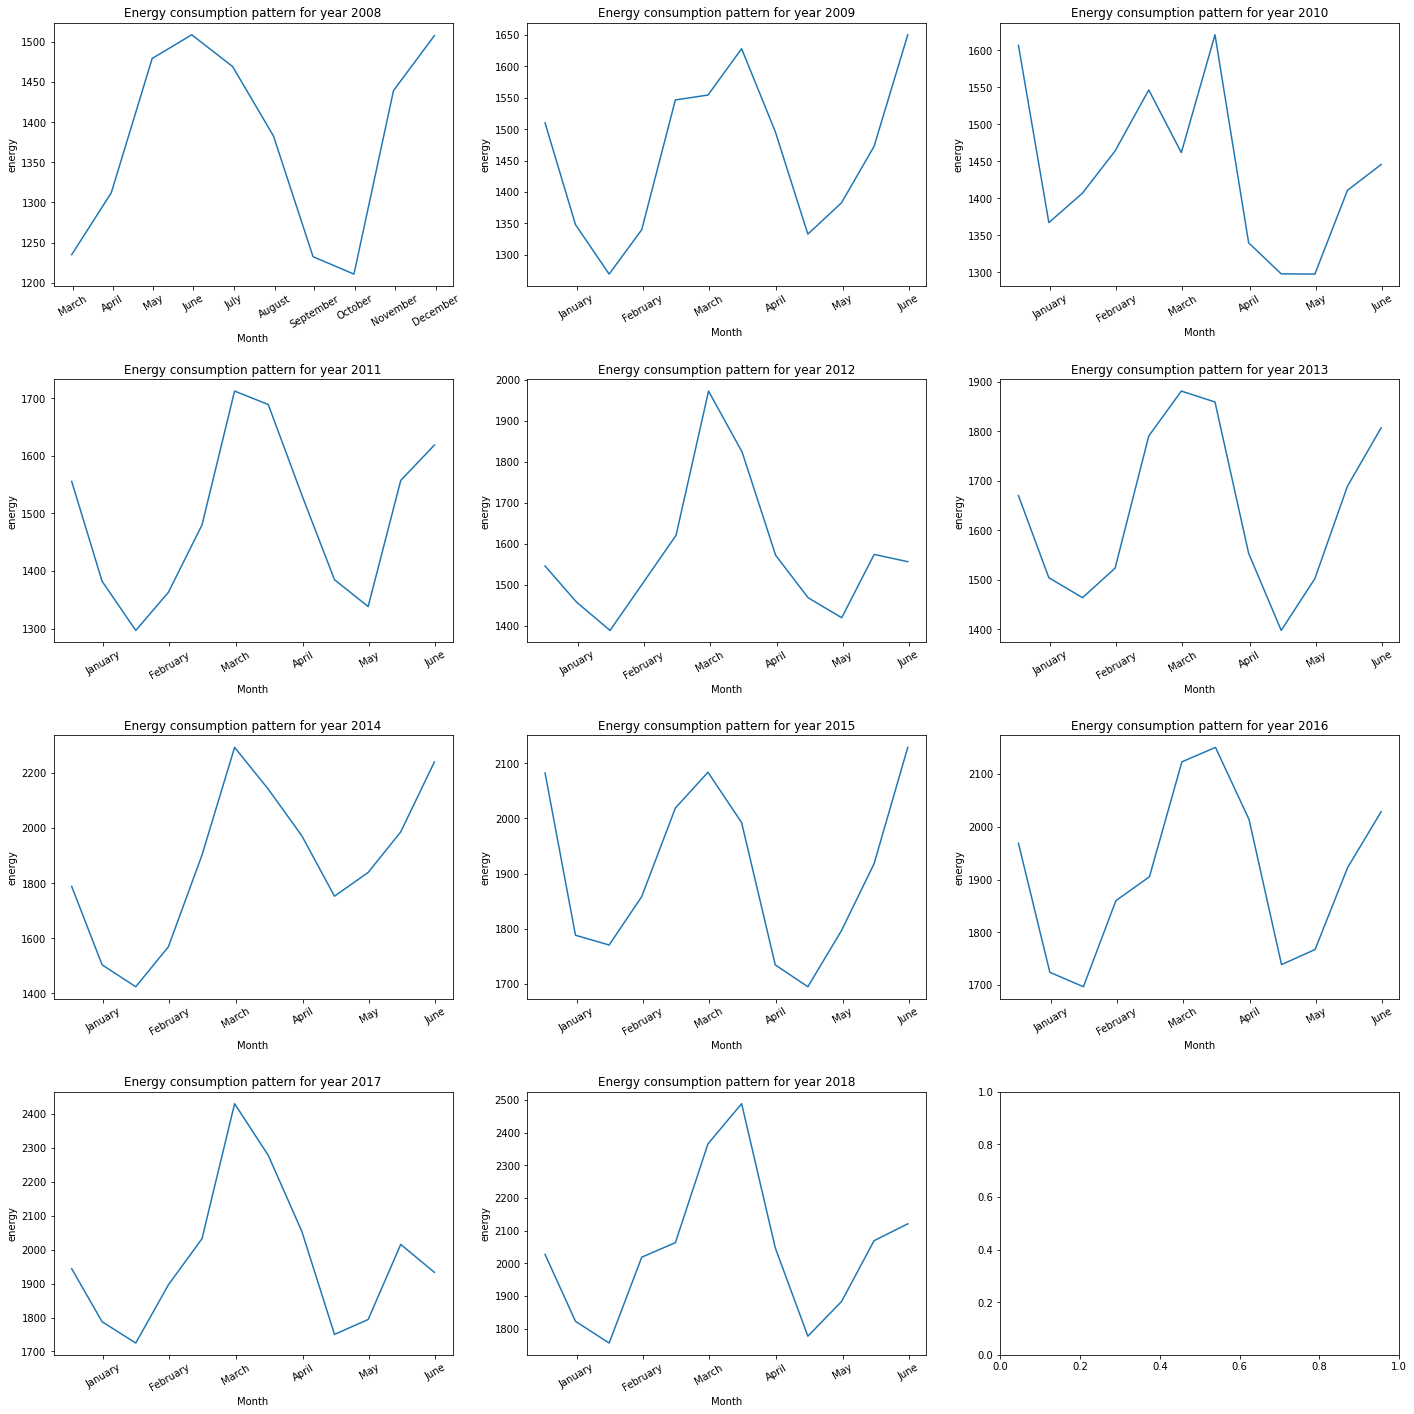

In [ ]:
consumption_patttern(train_df)

In [ ]:
def create_weekend(df):
    df['is_weekend'] = (df.index.dayofweek > 4).astype('int')
    # df['is_weekend'] = (df['is_weekend'].dt.dayofweek > 4).map({True: 1, False: 0})
    return df
   

In [ ]:
train_df = create_weekend(train_df)
test_df = create_weekend(test_df)

In [ ]:
display(train_df['is_weekend'].value_counts())
display(test_df['is_weekend'].value_counts())

0    67824
1    27168
Name: is_weekend, dtype: int64

0    18816
1     7488
Name: is_weekend, dtype: int64

In [ ]:
display(train_df.describe()),display(train_df.info())

,row_id,energy,is_weekend
count,94992.000000,93092.000000,94992.000000
mean,47496.500000,1702.995014,0.286003
std,27421.972723,369.322103,0.451893
min,1.000000,866.388600,0.000000
25%,23748.750000,1431.541100,0.000000
50%,47496.500000,1654.465800,0.000000
75%,71244.250000,1935.993450,1.000000
max,94992.000000,3374.399600,1.000000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 94992 entries, 2008-03-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   row_id      94992 non-null  int64  
 1   energy      93092 non-null  float64
 2   is_weekend  94992 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 2.9 MB


None

(None, None)

## 3. Null handling strategy

In [ ]:
train_df.isna().sum()/len(train_df)

row_id        0.000000
energy        0.020002
is_weekend    0.000000
dtype: float64

In [ ]:
# train_df.query('~energy.isna()',engine='python').isna().count(), train_df.count(), train_df[~train_df.energy.isna()].count()

In [ ]:
def null_handler(df , strat = 'drop'):
    """"
    Strategy to use for handling null values in times series
    """
    if strat == 'drop':
        # dumb start/ not worth to even mention/ don't use, doesn't make sense
        # especially in timesries
        df = df[~df.energy.isna()]
    elif strat == 'ffill':
        df['energy'] = df['energy'].ffill()
    elif strat == 'bfill':
        df['energy'] = df['energy'].bfill() 
    elif strat == 'sma':
        # average interval for spike in energy consumption -- can do domain specific search and learn the number in hours
        df['energy'] = df['energy'].rolling(window=5).mean()
    elif strat == 'wma':
        df['energy'] = df['energy'].rolling(window=5).apply(lambda x: x[::-1].cumsum().sum() * 2 / n / (n + 1))
    elif strat == 'ewma':
        df['energy'] = df['energy'].ewm(halflife=4).mean()
    elif strat == 'interpolate_spline':
        df['energy'] = df['energy'].interpolate(option='spline')
    elif strat == 'interpolate_linear':
        df['energy'] = df['energy'].interpolate(option='linear')
    elif strat == 'interpolate_time':
        df['energy'] = df['energy'].interpolate(option='time')
    return df

In [ ]:
# NULL handle strategy applied
train_df = null_handler(train_df,'interpolate_linear')

#### Setting freq = 'H' for train dataset

In [ ]:
df_train = train_df.asfreq('H')
df_test  = test_df.asfreq('H')

### observing trend and seasonality

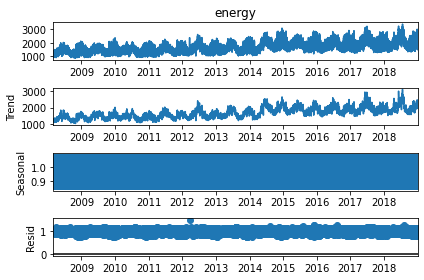

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_train['energy'], model='mul')  # model='mul' also works
result.plot();

## 4.Train-Test splits

In [ ]:
def part_of_day(x):
  if x < dt.time(5,0):
    return 3
  if x > dt.time(21,0):
    return 3
  if x >= dt.time(5,0) and x <= dt.time(12,0):
    return 0
  if x <= dt.time(17,0):
    return 1
  if x <= dt.time(21,0):
    return 2

In [ ]:
class feature_creator:
  def __init__(self, df):
    self.df = df

  def part_of_day(x):
    if x < dt.time(5,0):
      return 3
    if x > dt.time(21,0):
      return 3
    if x >= dt.time(5,0) and x <= dt.time(12,0):
      return 0
    if x <= dt.time(17,0):
      return 1
    if x <= dt.time(21,0):
      return 2
  
  def transform(self):
    self.df['dow'] = self.df.index.dayofweek
    self.df['doy'] = self.df.index.dayofyear
    self.df['year'] = self.df.index.year
    self.df['month'] = self.df.index.month
    self.df['quarter'] = self.df.index.quarter
    self.df['hour'] = self.df.index.hour
    # self.df['weekday'] = self.df.index.weekday_name
    self.df['woy'] = self.df.index.weekofyear
    self.df['dom'] = self.df.index.day # Day of Month
    self.df['date'] = self.df.index.date 

    # let's add the season number
    self.df['season'] = self.df['month'].apply(lambda month_number: (month_number%12 + 3)//3)
    self.df['day_parts'] = pd.Series(self.df.index.time).apply(lambda x: part_of_day(x)).values
    return self.df


In [ ]:
test_features  = feature_creator(test_df)
test_df = test_features.transform()
train_features  = feature_creator(train_df)
train_df = train_features.transform()

In [ ]:
pandas_profiling.ProfileReport(train_df)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
train_df.corr()['energy'].sort_values()[:-2]

day_parts    -0.090037
is_weekend   -0.059581
season       -0.036008
dom           0.004632
dow           0.024411
doy           0.061013
woy           0.061312
month         0.061762
quarter       0.068894
hour          0.319881
year          0.608042
Name: energy, dtype: float64

In [ ]:
# aggregation
_ = (train_df
    .groupby(['hour', 'is_weekend'], as_index=False)
    .agg({'energy':'median'})
    )

# plotting
fig = px.line(_, 
              x='hour', 
              y='energy', 
              color='is_weekend', 
              title='Median Hourly Power consumpiton weekend vs weekday'
              )
fig.update_layout(xaxis_title='Hour', yaxis_title='Energy consumption')
fig.show()

In [ ]:
# aggregation
_ = (train_df
    .groupby(['hour', 'dow'], as_index=False)
    .agg({'energy':'median'})
    )
_['week_day_name'] = _['dow'].map({0:'MONDAY',1:'TUESDAY',2:'WEDNESDAY',3:'THURSDAY',4:'FRIDAY',5:'SATURDAY',6:'SUNDAY'})

# plotting
fig = px.line(_, 
              x='hour', 
              y='energy', 
              color='week_day_name', 
              title='Median Hourly Power consumpiton Weekdays'
              )
fig.update_layout(xaxis_title='Hour', yaxis_title='Energy consumption')
fig.show()

In [ ]:
# aggregation
_ = (train_df
    .groupby(['hour',  'season'], as_index=False)
    .agg({'energy':'median'})
    )

# plotting
fig = px.line(_, 
              x='hour', 
              y='energy', 
              color= 'season', 
              title='Median Hourly Power consumpiton per season'
              )
fig.update_layout(xaxis_title='Hour', yaxis_title='Energy consumption')
fig.show()

In [ ]:
# aggregation
_ = (train_df
    .groupby(['day_parts'], as_index=False)
    .agg({'energy':'mean'})
    )

# plotting
fig = px.bar(_, 
              x='day_parts', 
              y='energy', 
              text_auto=True, 
              title='Average Power consumpiton at different parts of a day'
              )
fig.update_layout(xaxis_title='Day Part', yaxis_title='Energy consumption')

fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()

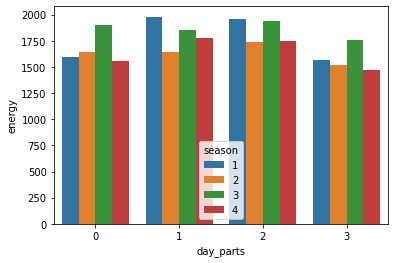

In [ ]:
_ = (train_df
    .groupby(['day_parts','season'])
    .agg({'energy':'mean'})
    .reset_index()
    )
# display(_)
sns.barplot(data = _,x='day_parts', y = 'energy', hue='season' )


In [ ]:
# aggregation
_ = (train_df
    .groupby(['day_parts','season'], as_index=False)
    .agg({'energy':'mean'})
    )

# plotting
fig = px.bar(_, 
              x='day_parts', 
              y='energy', 
              color= 'season',
              text_auto=True, 
              title='Average Power consumpiton at different parts of a day per season'
              )
fig.update_layout(xaxis_title='Day Part', yaxis_title='Energy consumption')
fig.show()

In [ ]:
# aggregation
_ = (train_df
    .groupby(['day_parts','is_weekend'], as_index=False)
    .agg({'energy':'mean'})
    )

# plotting
fig = px.bar(_, 
              x='day_parts', 
              y='energy', 
              color= 'is_weekend',
              # barmode="group", 
              text_auto=True,
              title='Average Power consumpiton at different parts of a day'
              )
fig.update_layout(xaxis_title='Day parts', yaxis_title='Energy consumption')
fig.update_layout(barmode='group')
fig.show()



In [ ]:
# df_train.index.year.unique()
len(train_df['2018']), len(train_df[:'2017']) + len(train_df['2018']), len(train_df)

(8760, 94992, 94992)

In [ ]:
train_data = train_df[:'2017']  
test_data = train_df['2018']

In [ ]:
display(train_data.head(2))
display(test_data.head(2))


,row_id,energy,is_weekend,dow,doy,year,month,quarter,hour,woy,dom,date,season,day_parts
datetime,,,,,,,,,,,,,,
2008-03-01 00:00:00,1,1259.985563,1,5,61,2008,3,1,0,9,1,2008-03-01,2,3
2008-03-01 01:00:00,2,1095.541500,1,5,61,2008,3,1,1,9,1,2008-03-01,2,3


,row_id,energy,is_weekend,dow,doy,year,month,quarter,hour,woy,dom,date,season,day_parts
datetime,,,,,,,,,,,,,,
2018-01-01 00:00:00,86233,1642.7628,0,0,1,2018,1,1,0,1,1,2018-01-01,1,3
2018-01-01 01:00:00,86234,1553.2090,0,0,1,2018,1,1,1,1,1,2018-01-01,1,3


## 5.Fitting the Model

In [ ]:
dc =['date','row_id','energy']#,'quarter','is_weekend','woy','month','dom']
train_X = train_data.drop(dc,axis=1)
train_y= train_data['energy']
test_X = test_data.drop(dc,axis=1)
test_y = test_data['energy']

In [ ]:
model = XGBRegressor(objective='reg:squarederror')
model.fit(train_X, train_y)

XGBRegressor(objective='reg:squarederror')

In [ ]:
train_preds = model.predict(train_X)
test_preds = model.predict(test_X)

In [ ]:
# Train_predictions:
np.sqrt(mean_squared_error(train_y, train_preds)),  mean_absolute_error(train_y, train_preds)
# -drop day_parts - 21677.277007623048
#includ day_parts - 21571.09296513606
# 146.8710079121678

(146.8710079121678, 112.21286822615842)

In [ ]:
MSE = np.square(np.subtract(train_y,train_preds)).mean() 
np.sqrt(MSE)

146.8710079121678

In [ ]:
# Test_predictions:
np.sqrt(mean_squared_error(test_y, test_preds)),  mean_absolute_error(test_y, test_preds)
# -drop day_parts - 21677.277007623048
#includ day_parts - 21571.09296513606
# 146.8710079121678

(212.62082855733834, 150.30047362394615)

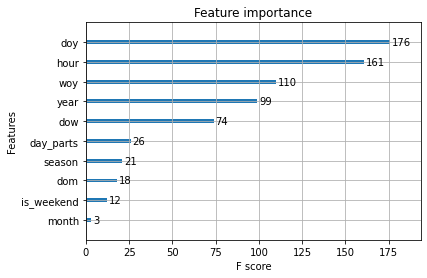

In [ ]:
plot_importance(model)

In [ ]:
train_y.std(), train_preds.std() #.describe()

(353.64798336519897, 301.2612)

In [ ]:
pd.DataFrame(train_y)
# pd.DataFrame(train_preds,index=train_y.index,columns=['energy'])

,energy
datetime,
2008-03-01 00:00:00,1259.985563
2008-03-01 01:00:00,1095.541500
2008-03-01 02:00:00,1056.247500
2008-03-01 03:00:00,1034.742000
2008-03-01 04:00:00,1026.334500
...,...
2017-12-31 19:00:00,1942.416000
2017-12-31 20:00:00,1894.776800
2017-12-31 21:00:00,1868.062000


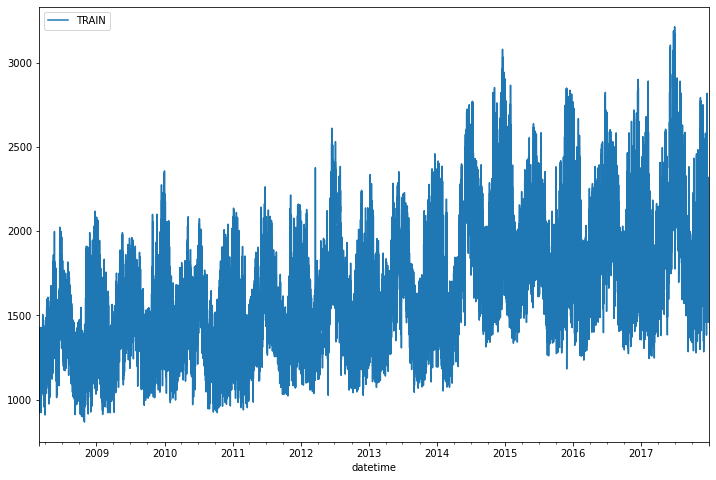

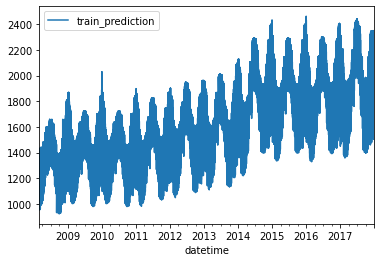

In [ ]:
train_y.plot(legend=True,label='TRAIN',figsize=(12,8))
# test_y['energy'].plot(legend=True,label='TEST',figsize=(12,8))
pd.DataFrame(train_preds,index=train_y.index,columns=['train_prediction']).plot(legend=True,label='PREDICTION');

## Forecasting into Future

In [ ]:
dc1 = set(dc) - {'energy'}
final_test_preds = model.predict(test_df.drop(dc1,axis=1))

In [ ]:
len(test_df),len(final_test_preds)

(26304, 26304)

In [ ]:
gb_sub = pd.DataFrame(final_test_preds,index=test_df.row_id)

In [ ]:
gb_sub.to_csv('/content/drive/MyDrive/AV_NOV_2022/modelsub3_gb.csv',index=True)